# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
#Leggo il dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df_Multi = pd.read_csv('TimeSeries_DataSet/DataSet_Multi_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_Occupancy = pd.read_csv('TimeSeries_DataSet/Occupancy/Occupancy_5Giorni.csv', parse_dates=True, index_col='date', date_parser=dateparse)

# Data Partitioning e Preparation

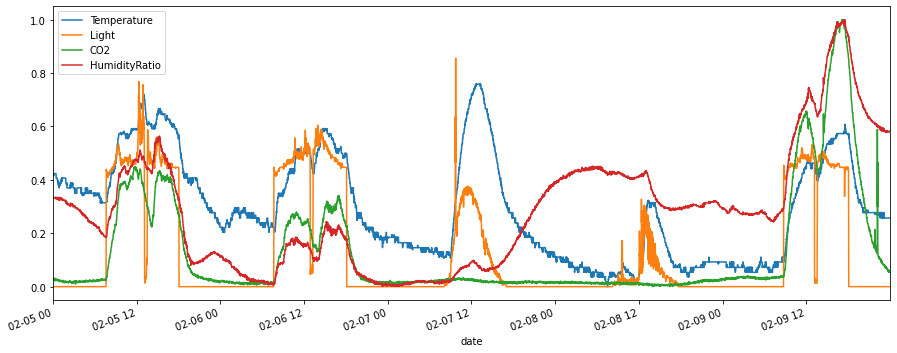

In [4]:
#Leggo la Time Series e plotto
ts_Multi = df_Multi
ts_Multi.plot(figsize=(15, 6))
plt.xticks(rotation=20)
plt.show()

#Creo la lista con la divisione ad ore
Multi_hour_list = []
for i in range(0, 24*5):
    Multi_hour_list.append(ts_Multi.values[60*i:60*(i+1)])
#Creo la lista con la divisione a 6 ore
Multi_6hour_list = []
k = 0
for i in range(0, 20):
    Multi_6hour_list.append(ts_Multi.values[360*i:360*(i+1)])

#Trasformo in array
Multi_H_array = np.array(Multi_hour_list)
Multi_6H_array = np.array(Multi_6hour_list)

#Occupancy
ts_Occupancy = df_Occupancy['Occupancy']
Occupancy_array = np.array(ts_Occupancy.values)

occ_ls = []
k = 0
for times in Multi_H_array: #cambiare questo
    cont1 = 0
    for i in times:
        if Occupancy_array[k] ==1:
            cont1 = cont1 + 1
        k = k + 1
    if cont1 > (len(times)/2):
        occ_ls.append(1)
    else:
        occ_ls.append(0)
    
occ_array = np.array(occ_ls)

In [5]:
y = occ_array
X = Multi_H_array
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify = y)

In [6]:
print(X_train.shape)
print(X_test.shape)

(84, 60, 4)
(36, 60, 4)


In [11]:
y_train

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
X_train = X_train.reshape(84,60, 4)
X_test = X_test.reshape(36, 60,4)

In [14]:
print(X_train.shape)
print(X_test.shape)

(84, 60, 4)
(36, 60, 4)


In [27]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_train)), X_train.shape[2] 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)
print("N. FEATURES: ", n_features)

TIMESTEPS:  60
N. LABELS:  2
N. FEATURES:  4


# Shapelet Classifier

In [28]:
X_train.shape

(84, 60, 4)

In [29]:
X_test.shape

(36, 60, 4)

In [30]:
n_ts=X_train.shape[0]
ts_sz=X_train.shape[1]
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 84
ts_sz 60
n_classes 2
shapelet_sizes {6: 3}


In [31]:
# Define the model using parameters provided by the authors (except that we use
# fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

In [32]:
shp_clf.fit(X_train, y_train)

Epoch 1/200
84/84 [==============================] - 1s 6ms/step - loss: 0.6640 - binary_accuracy: 0.7976 - binary_crossentropy: 0.6395
Epoch 2/200
84/84 [==============================] - 0s 47us/step - loss: 0.6626 - binary_accuracy: 0.8095 - binary_crossentropy: 0.6381
Epoch 3/200
84/84 [==============================] - 0s 71us/step - loss: 0.6613 - binary_accuracy: 0.8095 - binary_crossentropy: 0.6367
Epoch 4/200
84/84 [==============================] - 0s 48us/step - loss: 0.6599 - binary_accuracy: 0.8095 - binary_crossentropy: 0.6353
Epoch 5/200
84/84 [==============================] - 0s 84us/step - loss: 0.6585 - binary_accuracy: 0.8095 - binary_crossentropy: 0.6340
Epoch 6/200
84/84 [==============================] - 0s 47us/step - loss: 0.6571 - binary_accuracy: 0.8095 - binary_crossentropy: 0.6326
Epoch 7/200
84/84 [==============================] - 0s 71us/step - loss: 0.6558 - binary_accuracy: 0.8095 - binary_crossentropy: 0.6312
Epoch 8/200
84/84 [=======================

Epoch 61/200
84/84 [==============================] - 0s 47us/step - loss: 0.5956 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5709
Epoch 62/200
84/84 [==============================] - 0s 59us/step - loss: 0.5946 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5699
Epoch 63/200
84/84 [==============================] - 0s 36us/step - loss: 0.5937 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5690
Epoch 64/200
84/84 [==============================] - 0s 71us/step - loss: 0.5928 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5681
Epoch 65/200
84/84 [==============================] - 0s 36us/step - loss: 0.5919 - binary_accuracy: 0.7738 - binary_crossentropy: 0.5672
Epoch 66/200
84/84 [==============================] - 0s 71us/step - loss: 0.5910 - binary_accuracy: 0.7738 - binary_crossentropy: 0.5663
Epoch 67/200
84/84 [==============================] - 0s 48us/step - loss: 0.5901 - binary_accuracy: 0.7738 - binary_crossentropy: 0.5654
Epoch 68/200
84/84 [==============

Epoch 121/200
84/84 [==============================] - 0s 59us/step - loss: 0.5499 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5247
Epoch 122/200
84/84 [==============================] - 0s 36us/step - loss: 0.5493 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5241
Epoch 123/200
84/84 [==============================] - 0s 71us/step - loss: 0.5486 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5235
Epoch 124/200
84/84 [==============================] - 0s 48us/step - loss: 0.5480 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5228
Epoch 125/200
84/84 [==============================] - 0s 47us/step - loss: 0.5474 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5222
Epoch 126/200
84/84 [==============================] - 0s 83us/step - loss: 0.5468 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5216
Epoch 127/200
84/84 [==============================] - 0s 59us/step - loss: 0.5462 - binary_accuracy: 0.7857 - binary_crossentropy: 0.5210
Epoch 128/200
84/84 [======

Epoch 180/200
84/84 [==============================] - 0s 59us/step - loss: 0.5183 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4926
Epoch 181/200
84/84 [==============================] - 0s 59us/step - loss: 0.5178 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4921
Epoch 182/200
84/84 [==============================] - 0s 71us/step - loss: 0.5174 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4917
Epoch 183/200
84/84 [==============================] - 0s 107us/step - loss: 0.5169 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4912
Epoch 184/200
84/84 [==============================] - 0s 59us/step - loss: 0.5165 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4907
Epoch 185/200
84/84 [==============================] - 0s 36us/step - loss: 0.5160 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4903
Epoch 186/200
84/84 [==============================] - 0s 36us/step - loss: 0.5156 - binary_accuracy: 0.7857 - binary_crossentropy: 0.4898
Epoch 187/200
84/84 [=====

ShapeletModel(batch_size=256, max_iter=200, n_shapelets_per_size={6: 3},
              optimizer='sgd', random_state=None, shapelet_length=0.15,
              total_lengths=3, verbose=1, verbose_level=None,
              weight_regularizer=0.01)

In [33]:
y_pred = shp_clf.predict(X_test)

36/36 [==============================] - 0s 4ms/step


In [37]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.75
F1-score [0.85245902 0.18181818]
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        28
           1       0.33      0.12      0.18         8

    accuracy                           0.75        36
   macro avg       0.56      0.53      0.52        36
weighted avg       0.69      0.75      0.70        36



# Shaplet-distances-based Classifier

In [38]:
X_train2 = shp_clf.transform(X_train)

84/84 [==============================] - 0s 1ms/step


In [39]:
X_train2.shape

(84, 3)

In [40]:
X_test2 = shp_clf.transform(X_test)

36/36 [==============================] - 0s 55us/step


In [41]:
#KNN

In [42]:
clf = KNeighborsClassifier(n_neighbors=3, weights='uniform') #parametri da scegliere
clf.fit(X_train2, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [43]:
y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9166666666666666
F1-score [0.94545455 0.82352941]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.78      0.88      0.82         8

    accuracy                           0.92        36
   macro avg       0.87      0.90      0.88        36
weighted avg       0.92      0.92      0.92        36



In [44]:
##DecisionTree

In [45]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=2, min_samples_split=2, random_state=200)
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8611111111111112
F1-score [0.90566038 0.73684211]
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        28
           1       0.64      0.88      0.74         8

    accuracy                           0.86        36
   macro avg       0.80      0.87      0.82        36
weighted avg       0.89      0.86      0.87        36



# Feature-based Classifier

The basic idea is to:
1. Extract global features from the time series,
2. Create a feature vector, and
3. Use it to as input for machine learning
classifiers
• Example of features:
• mean, variance, skewness, kurtosis,
• 1st derivative mean, 1st derivative variance, …
• parameters of regression, forecasting, Markov
model

In [76]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        #'var': np.var(values),
        #'med': np.median(values),
        '10p': np.percentile(values, 10),
        #'25p': np.percentile(values, 25),
        #'50p': np.percentile(values, 50),
        #'75p': np.percentile(values, 75),
        #'90p': np.percentile(values, 90),
        #'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values)
        #'skw': stats.skew(values),
        #'kur': stats.kurtosis(values)
    }

    return features

In [77]:
X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])

In [78]:
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

In [79]:
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train3, y_train)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 1.0
F1-score [1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



# CNN Classifier

In [16]:
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [17]:
X_train_cnn.shape

(67, 60, 4)

In [18]:
X_val_cnn.shape

(17, 60, 4)

In [19]:
y_train_cnn.shape

(67,)

In [20]:
y_val_cnn.shape

(17,)

In [13]:
def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

"def build_lstm2(n_timesteps, n_outputs, n_features):\n    model = Sequential()\n    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, \n                        kernel_initializer='TruncatedNormal'))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n    model.add(Dropout(0.3))\n    \n    #1\n    for _ in range(2):\n        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))\n        model.add(BatchNormalization())\n        model.add(LeakyReLU())\n        model.add(Dropout(0.04))   \n\n    #2\n    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n    model.add(Dropout(0.7))\n    \n    #3\n    for _ in range(2):\n        model.add(Dense(256, kernel_initializer='TruncatedNormal'))\n        model.add(BatchNormalization())\n        model.add(LeakyReLU())\n        model.add(Dropout(0.2))\n    #4\n    for _ in range(1):\n  

In [2]:
lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

NameError: name 'build_lstm2' is not defined

In [43]:
lstm2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 4)             144       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 4)             16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 4)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 4)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 4)             144       
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 4)             16        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 4)            

In [78]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [91]:
#con un numero minore di epochs si ottengono risultati migliori per accuracy e f1
history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=8, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Train on 67 samples, validate on 17 samples
Epoch 1/8
67/67 [==============================] - 1s 9ms/step - loss: 0.0594 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 2/8
67/67 [==============================] - 1s 9ms/step - loss: 0.1026 - accuracy: 0.9701 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 3/8
67/67 [==============================] - 1s 8ms/step - loss: 0.0508 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/8
67/67 [==============================] - 1s 9ms/step - loss: 0.1090 - accuracy: 0.9552 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 5/8
67/67 [==============================] - 1s 9ms/step - loss: 0.1343 - accuracy: 0.9552 - val_loss: 0.1197 - val_accuracy: 1.0000
Epoch 6/8
67/67 [==============================] - 1s 9ms/step - loss: 0.1151 - accuracy: 0.9552 - val_loss: 0.1461 - val_accuracy: 1.0000
Epoch 7/8
67/67 [==============================] - 1s 9ms/step - loss: 0.1066 - accuracy: 0.9701 - val_loss: 0.0988 - val_

In [92]:
#con epochs = 8 ho ottenuto accuracy = 0.972222 e f1= 0.982456

y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9722222222222222
F1-score [0.98245614 0.93333333]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.88      0.93         8

    accuracy                           0.97        36
   macro avg       0.98      0.94      0.96        36
weighted avg       0.97      0.97      0.97        36



In [21]:
X_train_cnn.shape

(67, 60, 4)

In [29]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train_cnn2.shape


(67, 60, 4, 1)

In [30]:
n_features

4

In [31]:
X_val_cnn.shape[0]

17

In [32]:
X_val_cnn.shape[1]

60

In [33]:
X_val_cnn.shape[2]

4

In [34]:
 X_train_cnn.shape[1]

60

In [35]:
len(np.unique(y_train_cnn))

2

In [36]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [37]:
cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn2.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [39]:
X_val_cnn2.shape

(17, 60, 4, 1)

In [40]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=3, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

Instructions for updating:
Use tf.cast instead.
Train on 67 samples, validate on 17 samples
Epoch 1/3
67/67 [==============================] - 3s 50ms/step - loss: 0.8634 - accuracy: 0.6269 - val_loss: 0.6694 - val_accuracy: 0.7647
Epoch 2/3
67/67 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.6567 - val_loss: 0.6544 - val_accuracy: 0.7647
Epoch 3/3
67/67 [==============================] - 0s 3ms/step - loss: 0.7275 - accuracy: 0.6567 - val_loss: 0.6449 - val_accuracy: 0.7647


In [138]:
#con epochs = 3 ho ottenuto accuracy = 0.97222222 e f1 = 0.982456
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9722222222222222
F1-score [0.98245614 0.93333333]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.88      0.93         8

    accuracy                           0.97        36
   macro avg       0.98      0.94      0.96        36
weighted avg       0.97      0.97      0.97        36

